In [ ]:
#using these guides
#https://datascience.stackexchange.com/questions/93180/trying-to-extend-this-code-to-include-additional-feature-volume-in-addition-to
#https://datascience.stackexchange.com/questions/91147/problems-to-understand-how-to-create-the-input-data-for-time-series-forecasting/92395?noredirect=1#comment97317_92395
#https://towardsdatascience.com/recurrent-neural-networks-for-electricity-price-prediction-a26f8411ea44
#https://github.com/Carterbouley/ElectricityPricePrediction
#https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

In [29]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
import pandas as pd
import yfinance as yf
import numpy as np
import sklearn
from yahoofinancials import YahooFinancials
AMZN = yf.download('AMZN', 
                      start='2013-01-01', 
                      end='2019-12-31', 
                      progress=False)
# AMZN = yf.download('AMZN') for all 
all_data = AMZN[['Adj Close','Volume']].round(2)
all_data.head(10)

,Adj Close,Volume
Date,,
2013-01-02,257.31,3271000
2013-01-03,258.48,2750900
2013-01-04,259.15,1874200
2013-01-07,268.46,4910000
2013-01-08,266.38,3010700
2013-01-09,266.35,2265600
2013-01-10,265.34,2863400
2013-01-11,267.94,2413300
2013-01-14,272.73,4275000


In [23]:
len(all_data)
#len(all_data.columns)


1569

In [27]:
import tensorflow as tf

from tensorflow import keras
from matplotlib import pyplot as plt

# Read the data for the parameters from a csv file
import urllib.request
#Delete the first column as it is not used in the tutorial for forecasting

data = all_data.values

n_steps = 168
n_ahead = 24

training = ((len(all_data)-n_steps-n_ahead)*.714)
validation = ((len(all_data)-n_steps-n_ahead)*.856)

series_reshaped =  np.array([data[i:i + (n_steps+n_ahead)].copy() for i in range(len(data) - (n_steps+n_ahead))])


X_train = series_reshaped[:int(training), :n_steps] 
X_valid = series_reshaped[int(training):int(validation), :n_steps] 
X_test = series_reshaped[int(validation):, :n_steps] 
Y = np.empty(((len(all_data) - n_steps - n_ahead), n_steps, n_ahead))  
for step_ahead in range(1, n_ahead + 1):     
   Y[..., step_ahead - 1] =   series_reshaped[..., step_ahead:step_ahead + n_steps, 0]
 
Y_train = Y[:int(training)] 
Y_valid = Y[int(training):int(validation)] 
Y_test = Y[int(validation):]

np.random.seed(42)
tf.random.set_seed(42)

model6 = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, len(all_data.columns)]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(n_ahead))
])

model6.compile(loss="mean_squared_error", optimizer="adam", metrics=['mean_absolute_percentage_error'])
history = model6.fit(X_train, Y_train, epochs=10,batch_size=64,
                    validation_data=(X_valid, Y_valid))

Epoch 1/10
18/18 [==============================] - 2s 67ms/step - loss: 363006.3405 - mean_absolute_percentage_error: 99.9785 - val_loss: 2325305.0000 - val_mean_absolute_percentage_error: 99.9685
Epoch 2/10
18/18 [==============================] - 1s 57ms/step - loss: 376184.5312 - mean_absolute_percentage_error: 99.8803 - val_loss: 2323973.2500 - val_mean_absolute_percentage_error: 99.9377
Epoch 3/10
18/18 [==============================] - 1s 52ms/step - loss: 374857.1859 - mean_absolute_percentage_error: 99.7813 - val_loss: 2322506.0000 - val_mean_absolute_percentage_error: 99.9036
Epoch 4/10
18/18 [==============================] - 1s 51ms/step - loss: 364866.3980 - mean_absolute_percentage_error: 99.6733 - val_loss: 2321062.2500 - val_mean_absolute_percentage_error: 99.8701
Epoch 5/10
18/18 [==============================] - 1s 52ms/step - loss: 380415.4523 - mean_absolute_percentage_error: 99.5746 - val_loss: 2319696.7500 - val_mean_absolute_percentage_error: 99.8384
Epoch 6/10

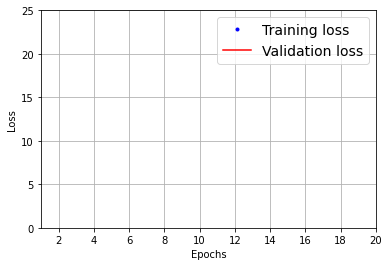

In [30]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 25])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()